In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*

In [2]:
# Imports
import sys
import math
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

# Data

In [5]:
# Read data
path = '../../../dataset4_wbc/live_extraction/aliengo/step_0.065/continuous_1m.csv'
motion = np.genfromtxt(path, delimiter=',', dtype=np.float64)
contacts = np.genfromtxt(path, delimiter=',', usecols=(29, 30, 31, 32), dtype=bool)
print("Motion data has a length of ", len(motion))

Motion data has a length of  8334


In [6]:
motion.shape

(8334, 33)

## Height-Force plots

In [7]:
def get_specific_cmd(dataset, fwd, side, rot):
    if abs(fwd): 
        return np.where(dataset[:, 1] > 0)[0] if fwd > 0 else np.where(dataset[:, 1] < 0)[0]
    if abs(side): 
        return np.where(dataset[:, 2] > 0)[0] if side > 0 else np.where(dataset[:, 2] < 0)[0]
    if abs(rot): 
        return np.where(dataset[:, 3] > 0)[0] if rot > 0 else np.where(dataset[:, 3] < 0)[0]

In [8]:
def get_swinging_motions(dataset, height=1):
    # rf min height (i.e swining motion)
    fl_min_height = np.where(dataset[:, 6] < height)[0]
    fr_min_height = np.where(dataset[:, 9] < height)[0]
    rl_min_height = np.where(dataset[:, 12] < height)[0]
    rr_min_height = np.where(dataset[:, 15] < height)[0]
            
    return fl_min_height,fr_min_height,rl_min_height,rr_min_height

### Footstep IDXs

In [9]:
footsteps_fwd = get_specific_cmd(motion, 1, 0, 0)
footsteps_clock = get_specific_cmd(motion, 0, 0, -1)
footsteps_count = get_specific_cmd(motion, 0, 0, 1)
footsteps_side_right = get_specific_cmd(motion, 0, -1, 0)
footsteps_side_left = get_specific_cmd(motion, 0, 1, 0)

# Dataset Preparation

In [10]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [11]:
def yaw_from_quaternion(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    x = Q[0]
    y = Q[1]
    z = Q[2]
    w = Q[3]
     
    return np.arctan2(2 * (w*z + x*y), 1 - 2 * (y*y + z*z))

In [12]:
def quaternion_rotation_matrix(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    q0 = Q[3]
    q1 = Q[0]
    q2 = Q[1]
    q3 = Q[2]
     
    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)
     
    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)
     
    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1
     
    # 3x3 rotation matrix
    rot_matrix = np.array([[r00, r01, r02],
                           [r10, r11, r12],
                           [r20, r21, r22]])
                            
    return rot_matrix

In [21]:
def create_com_dataset(dataset, footsteps, motion=None, debug=False):
    inputs = []
    labels = []
    
    for idx, footstep in enumerate(footsteps):
        if idx > 0:
            # Compute time difference between
            # current and next footsteps
            time_difference = abs(dataset[footsteps[idx], 0] - dataset[footsteps[idx-1], 0])
            
            if time_difference < 0.5 and np.any(dataset[footsteps[idx-1], 1:4]) and np.any(dataset[footsteps[idx], 1:4]):
                fl_moving = contacts[footsteps[idx], 0]
                fr_moving = contacts[footsteps[idx], 1]
                rl_moving = contacts[footsteps[idx], 2]
                rr_moving = contacts[footsteps[idx], 3]
                
                assert fr_moving == rl_moving
                assert rr_moving == fl_moving
                assert fr_moving != fl_moving

                # Compute rotation matrices from odometry orientation
                R_prev = quaternion_rotation_matrix(dataset[footsteps[idx-1], 19:23])
                R_curr = quaternion_rotation_matrix(dataset[footsteps[idx], 19:23])

                # Odom base vectors
                prev_base = np.array([[dataset[footsteps[idx-1], 16], dataset[footsteps[idx-1], 17], 0]])
                curr_base = np.array([[dataset[footsteps[idx], 16], dataset[footsteps[idx], 17], 0]])

                # Rotate odometry estimation
                rotated_prev_base = R_prev.T @ prev_base.T
                rotated_curr_base = R_prev.T @ curr_base.T
                base_displacement = rotated_curr_base - rotated_prev_base
                
                prev_yaw = yaw_from_quaternion(dataset[footsteps[idx-1], 19:23])
                curr_yaw = yaw_from_quaternion(dataset[footsteps[idx], 19:23])
                yaw = curr_yaw - prev_yaw
                
                if dataset[footsteps[idx-1], 3] != 0 and dataset[footsteps[idx], 3] != 0 and (prev_yaw < 0 and curr_yaw > 0) or (prev_yaw > 0 and curr_yaw < 0):
                    continue
                    
                inputs.append(dataset[footsteps[idx-1], 1:4].tolist() +
                              dataset[footsteps[idx-1], 23:29].tolist() +
                              #dataset[footsteps[idx-1], 4:16].tolist() + 
                              (dataset[footsteps[idx-1], 4:16].reshape(4,3) - dataset[footsteps[idx-1], 16:19].reshape(1,3)).reshape(12,).tolist() +
                              [fl_moving, fr_moving, rl_moving, rr_moving] +
                              dataset[footsteps[idx], 1:4].tolist())
                
                # Labels
                labels.append([base_displacement[0,0], base_displacement[1,0], yaw])
                
    return np.array(inputs, dtype=float), np.array(labels, dtype=float)
                
X_motion_fwd_CoM, Y_motion_fwd_CoM = create_com_dataset(motion, footsteps_fwd)
X_motion_clock_CoM, Y_motion_clock_CoM = create_com_dataset(motion, footsteps_clock)
X_motion_count_CoM, Y_motion_count_CoM = create_com_dataset(motion, footsteps_count)
X_motion_side_left_CoM, Y_motion_side_left_CoM = create_com_dataset(motion, footsteps_side_left)
X_motion_side_right_CoM, Y_motion_side_right_CoM = create_com_dataset(motion, footsteps_side_right)

# Stack datasets
X_motion_CoM_continuous = np.concatenate((X_motion_fwd_CoM, X_motion_side_right_CoM, X_motion_side_left_CoM, X_motion_clock_CoM, X_motion_count_CoM))
Y_motion_CoM_continuous = np.concatenate((Y_motion_fwd_CoM, Y_motion_side_right_CoM, Y_motion_side_left_CoM, Y_motion_clock_CoM, Y_motion_count_CoM))

print(X_motion_CoM_continuous.shape)
print(Y_motion_CoM_continuous.shape)

(7690, 28)
(7690, 3)


In [22]:
%store X_motion_CoM_continuous
%store Y_motion_CoM_continuous

Stored 'X_motion_CoM_continuous' (ndarray)
Stored 'Y_motion_CoM_continuous' (ndarray)


In [15]:
min(Y_motion_clock_CoM[:, 2])

-0.14356181392864276

### Fwd Plot

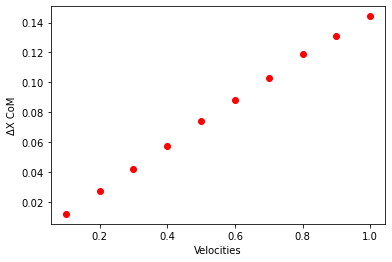

In [16]:
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
         [np.mean(Y_motion_fwd_CoM[np.where(np.isclose(X_motion_fwd_CoM[:, 0], velocity))[0], 0]) for velocity in np.arange(0.1, 1.1, 0.1)], 
         'ro')
plt.xlabel('Velocities')
plt.ylabel('\u0394X CoM')
plt.show()

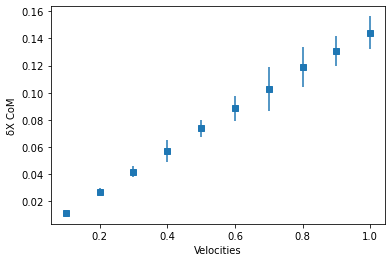

In [17]:
x = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
y = np.array([np.mean(Y_motion_fwd_CoM[np.where(np.isclose(X_motion_fwd_CoM[:, 0], velocity))[0], 0]) for velocity in np.arange(0.1, 1.1, 0.1)])
e = np.array([np.std(Y_motion_fwd_CoM[np.where(np.isclose(X_motion_fwd_CoM[:, 0], velocity))[0], 0]) for velocity in np.arange(0.1, 1.1, 0.1)])
plt.errorbar(x, y, e, linestyle='None', marker='s')
plt.xlabel('Velocities')
plt.ylabel('\u03B4X CoM')
plt.show()

### Left Plot

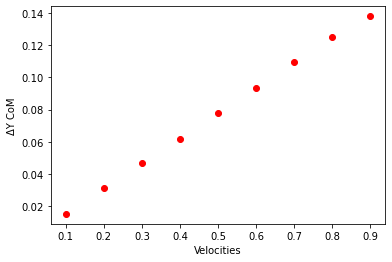

In [18]:
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         [np.mean(Y_motion_side_left_CoM[np.where(np.isclose(X_motion_side_left_CoM[:, 1], velocity))[0], 1]) for velocity in np.arange(0.1, 1.0, 0.1)], 
         'ro')
plt.xlabel('Velocities')
plt.ylabel('\u0394Y CoM')
plt.show()

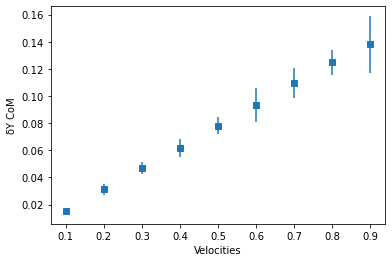

In [19]:
x = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
y = np.array([np.mean(Y_motion_side_left_CoM[np.where(np.isclose(X_motion_side_left_CoM[:, 1], velocity))[0], 1]) for velocity in np.arange(0.1, 1.0, 0.1)])
e = np.array([np.std(Y_motion_side_left_CoM[np.where(np.isclose(X_motion_side_left_CoM[:, 1], velocity))[0], 1]) for velocity in np.arange(0.1, 1.0, 0.1)])
plt.errorbar(x, y, e, linestyle='None', marker='s')
plt.xlabel('Velocities')
plt.ylabel('\u03B4Y CoM')
plt.show()

### Right Plot

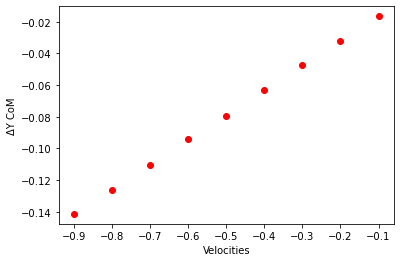

In [31]:
plt.plot([-0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9],
         [np.mean(Y_motion_side_right_CoM[np.where(np.isclose(X_motion_side_right_CoM[:, 1], -velocity))[0], 1]) for velocity in np.arange(0.1, 1.0, 0.1)], 
         'ro')
plt.xlabel('Velocities')
plt.ylabel('\u0394Y CoM')
plt.show()

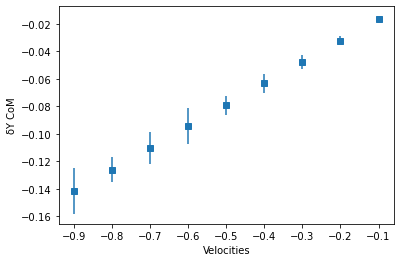

In [32]:
x = np.array([-0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9])
y = np.array([np.mean(Y_motion_side_right_CoM[np.where(np.isclose(X_motion_side_right_CoM[:, 1], -velocity))[0], 1]) for velocity in np.arange(0.1, 1.0, 0.1)])
e = np.array([np.std(Y_motion_side_right_CoM[np.where(np.isclose(X_motion_side_right_CoM[:, 1], -velocity))[0], 1]) for velocity in np.arange(0.1, 1.0, 0.1)])
plt.errorbar(x, y, e, linestyle='None', marker='s')
plt.xlabel('Velocities')
plt.ylabel('\u03B4Y CoM')
plt.show()

### Clock Plot

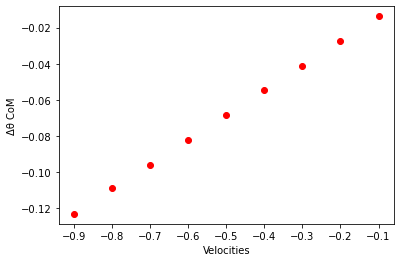

In [33]:
plt.plot([-0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9],
         [np.mean(Y_motion_clock_CoM[np.where(np.isclose(X_motion_clock_CoM[:, 2], -velocity))[0], 2]) for velocity in np.arange(0.1, 1.0, 0.1)], 
         'ro')
plt.xlabel('Velocities')
plt.ylabel('\u0394\u03B8 CoM')
plt.show()

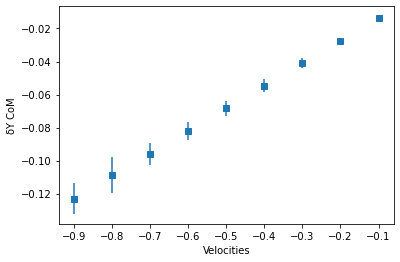

In [34]:
x = np.array([-0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9])
y = np.array([np.mean(Y_motion_clock_CoM[np.where(np.isclose(X_motion_clock_CoM[:, 2], -velocity))[0], 2]) for velocity in np.arange(0.1, 1.0, 0.1)])
e = np.array([np.std(Y_motion_clock_CoM[np.where(np.isclose(X_motion_clock_CoM[:, 2], -velocity))[0], 2]) for velocity in np.arange(0.1, 1.0, 0.1)])
plt.errorbar(x, y, e, linestyle='None', marker='s')
plt.xlabel('Velocities')
plt.ylabel('\u03B4Y CoM')
plt.show()

### Count Plot

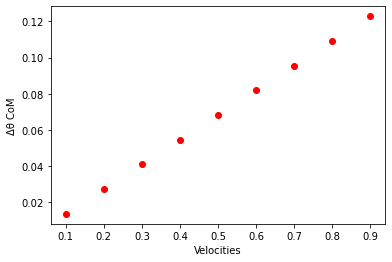

In [24]:
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         [np.mean(Y_motion_count_CoM[np.where(np.isclose(X_motion_count_CoM[:, 2], velocity))[0], 2]) for velocity in np.arange(0.1, 1.0, 0.1)], 
         'ro')
plt.xlabel('Velocities')
plt.ylabel('\u0394\u03B8 CoM')
plt.show()

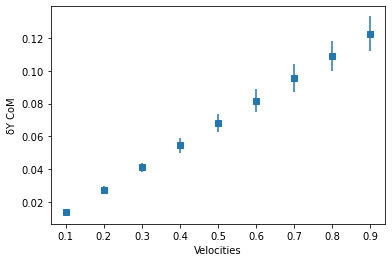

In [25]:
x = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
y = np.array([np.mean(Y_motion_count_CoM[np.where(np.isclose(X_motion_count_CoM[:, 2], velocity))[0], 2]) for velocity in np.arange(0.1, 1.0, 0.1)])
e = np.array([np.std(Y_motion_count_CoM[np.where(np.isclose(X_motion_count_CoM[:, 2], velocity))[0], 2]) for velocity in np.arange(0.1, 1.0, 0.1)])
plt.errorbar(x, y, e, linestyle='None', marker='s')
plt.xlabel('Velocities')
plt.ylabel('\u03B4Y CoM')
plt.show()

## Forwad Check

In [20]:
print(f"Min displacement: {min(Y_motion_fwd_CoM[:, 0])}. Max displacement: {max(Y_motion_fwd_CoM[:, 0])}")

Min displacement: 0.007236615679631823. Max displacement: 0.1536683363297584


## Clockwise Check

In [68]:
print(f"Min displacement: {min(Y_motion_clock_CoM[:, 2])}. Max displacement: {max(Y_motion_clock_CoM[:, 2])}")

Min displacement: -0.14356181392864276. Max displacement: -0.010198308354957638


## Counter Check

In [65]:
print(f"Min displacement: {min(Y_motion_count_CoM[:, 1])}. Max displacement: {max(Y_motion_count_CoM[:, 1])}")

Min displacement: -0.006205233617830874. Max displacement: 0.005427528135790061


## Left Check

In [23]:
print(f"Min displacement: {min(Y_motion_side_left_CoM[:, 1])}. Max displacement: {max(Y_motion_side_left_CoM[:, 1])}")

Min displacement: 0.007853730130729542. Max displacement: 0.09715947318711393


## Right Check

In [24]:
print(f"Min displacement: {min(Y_motion_side_right_CoM[:, 1])}. Max displacement: {max(Y_motion_side_right_CoM[:, 1])}")

Min displacement: -0.0944799924815003. Max displacement: -0.010731300881279493
